In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
from skimage import draw
from topostats.theme import Colormap
import math

In [11]:
cmap = Colormap("nanoscope").get_cmap()


def plot(image: np.ndarray, title: str = None, zlimit: bool = True, figsize: tuple = (8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin = -3
        vmax = 4
    else:
        vmin = None
        vmax = None
    ax.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Mon, 20 Nov 2023 09:29:25] [INFO    ] [topostats] Extracting image from /Users/sylvi/topo_data/Bradley/Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm
[Mon, 20 Nov 2023 09:29:25] [INFO    ] [topostats] Loading image from : /Users/sylvi/topo_data/Bradley/Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm
[Mon, 20 Nov 2023 09:29:25] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024] : Loaded image from : /Users/sylvi/topo_data/Bradley/Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm
[Mon, 20 Nov 2023 09:29:25] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024] : Extracted channel Height
[Mon, 20 Nov 2023 09:29:25] [INFO    ] [topostats] [20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024] : Pixel to nm scaling : 5.992138671875


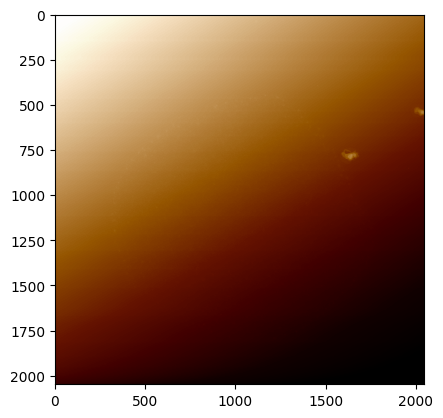

In [34]:
# Import SPM files
# Sylvia Paths
file = Path("/Users/sylvi/topo_data/Bradley/Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm")

# Bradley paths
# Fibril
# file = Path('./PristineZoom/20221213_KDNA001_MgCl2_H20Sit_Vacuum.0_00022.spm')
# file = Path('./PristineZoom/20230125_KPN005_25mMMgCl2_Vac.0_00009.spm')
# file = Path('./PristineZoom/20230125_KPN005_25mMMgCl2_Vac.0_00014.spm')
# file = Path('./PristineZoom/20230125_KPN005_25mMMgCl2_Vac.0_00018.spm')
# file = Path('./PristineZoom/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm')
# file = Path('./PristineZoom/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00021.spm')
# file = Path('./PristineZoom/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00028.spm')
# file = Path('PristineZoom/20230314_KPN015_25mMMgCl2_0.0_00018.spm')
# Cap
# file = Path('PristineZoom/Mid/20230314_KPN015_25mMMgCl2_0.0_00019.spm')
# file = Path('PristineZoom/Mid/20230417_KPN0018_Metal.0_00002.spm')
# file = Path('PristineZoom/Mid/20230417_KPN0018_Metal.0_00003.spm')
# file = Path('PristineZoom/Mid/20230417_KPN0018_Metal.0_00005.spm')

# Digested
# file = Path('./EP_Zoom/20230419_EPN005_Metal.0_00006.spm')

loadscans = LoadScans([file], "Height")
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw, cmap=cmap)

In [35]:
filters = topofilters.Filters(
    image=image_raw,
    filename=file,
    pixel_to_nm_scaling=p_to_nm,
    threshold_method="std_dev",
    row_alignment_quantile=0.05,
    threshold_std_dev={"upper": 1.0, "lower": None},
    gaussian_size=1.0,
    remove_scars={"run": False},
)

filters.filter_image()

[Mon, 20 Nov 2023 09:29:29] [INFO    ] [topostats] [/Users/sylvi/topo_data/Bradley/Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm] : Median flattening without mask
[Mon, 20 Nov 2023 09:29:29] [INFO    ] [topostats] [/Users/sylvi/topo_data/Bradley/Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm] : Plane tilt removal without mask
[Mon, 20 Nov 2023 09:29:29] [INFO    ] [topostats] [/Users/sylvi/topo_data/Bradley/Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm] : x-polyfit 1st order: [-3.23383531e-02  6.32335904e+01]
[Mon, 20 Nov 2023 09:29:29] [INFO    ] [topostats] [/Users/sylvi/topo_data/Bradley/Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm] : y-polyfit 1st order: [-9.46910011e-04  3.13355067e+01]
[Mon, 20 Nov 2023 09:29:29] [INFO    ] [topostats] [/Users/sylvi/topo_data/Bradley/Regular/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00024.spm] : Removing x plane tilt
[Mon, 20 Nov 2023 09:29:30] [INFO    ] [topostats] [/Users/sylvi/topo_data/Bradley/Regular/20230126_

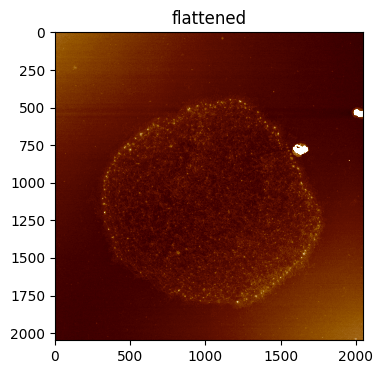

(2048, 2048)


In [36]:
flattened = filters.images["zero_average_background"]
plot(flattened, title="flattened", figsize=(4, 4))
print(flattened.shape)

In [29]:
def calculate_gradient(local_array: np.ndarray):
    # print("-- calculating gradient --")
    # print(f"local image:\n{local_array}")
    x_mean = np.mean(local_array, axis=0)
    # print(f"x mean: {x_mean}")
    y_mean = np.mean(local_array, axis=1)
    # print(f"y mean: {y_mean}")
    points = range(0, local_array.shape[0])
    # print(f"points: {points}")
    x_fit = np.polyfit(points, x_mean, deg=1)
    x_grad = x_fit[0]
    y_fit = np.polyfit(points, y_mean, deg=1)
    y_grad = y_fit[0]
    # print(f"gradients: x: {x_grad} y: {y_grad}")
    return x_grad, y_grad


def image_gradient(image: np.ndarray, kernel_size=3, max_gradient_colour_limit=5):
    # padded_image = np.pad(image, kernel_size//2+1, mode='constant', constant_values=np.mean(image))
    # padded_image = gaussian(padded_image, sigma=1)
    # padded_image[kernel_size//2+1:kernel_size//2+1+image.shape[0], kernel_size//2+1:kernel_size//2+1+image.shape[1]] = image
    # plot(padded_image, title='padded image')
    gradient_image = np.ones((image.shape[0], image.shape[1], 3)) * 0.5
    gradient_magnitude_image = np.zeros((image.shape[0], image.shape[0]))
    for j in range(kernel_size // 2, image.shape[0] - kernel_size // 2):
        for i in range(kernel_size // 2, image.shape[1] - kernel_size // 2):
            local_image = image[j - 1 : j + 2, i - 1 : i + 2]
            # plot(local_image)
            x_grad, y_grad = calculate_gradient(local_image)
            gradient_magnitude = abs(x_grad) + abs(y_grad)
            # print(f"gradients: x: {x_grad}, y: {y_grad} magnitude: {gradient_magnitude}")
            if x_grad > max_gradient_colour_limit:
                x_grad = max_gradient_colour_limit
            elif x_grad < -max_gradient_colour_limit:
                x_grad = -max_gradient_colour_limit
            if y_grad > max_gradient_colour_limit:
                y_grad = max_gradient_colour_limit
            elif y_grad < -max_gradient_colour_limit:
                y_grad = -max_gradient_colour_limit
            x_grad = 0.5 + x_grad * 0.5 / max_gradient_colour_limit
            y_grad = 0.5 + y_grad * 0.5 / max_gradient_colour_limit
            # print(f"colours: x: {x_grad} y: {y_grad}")
            gradient_image[j, i, 0] = x_grad
            gradient_image[j, i, 1] = y_grad
            gradient_magnitude_image[j, i] = gradient_magnitude
    return gradient_image, gradient_magnitude_image

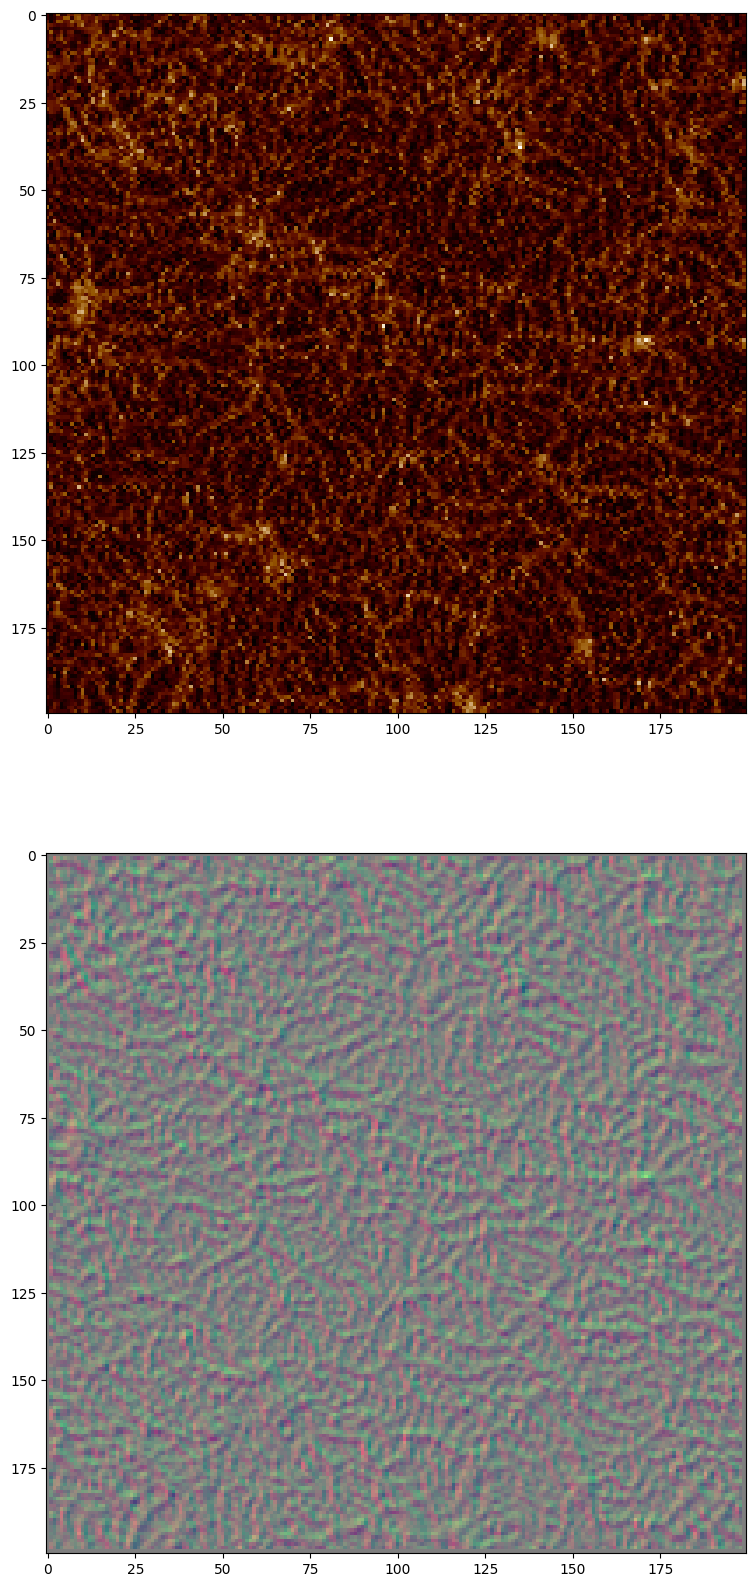

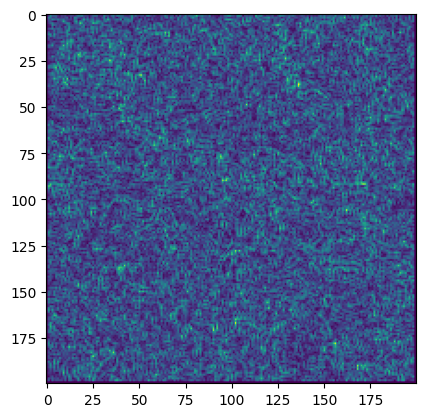

In [30]:
cropped = flattened[800:1000, 800:1000]
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
ax[0].imshow(cropped, cmap=cmap)

gradient_image, gradient_magnitude_image = image_gradient(cropped, kernel_size=3, max_gradient_colour_limit=2)

ax[1].imshow(gradient_image)
plt.show()


plt.imshow(gradient_magnitude_image)

thresholds: defaultdict(None, {'upper': 1.7238312858464222})
[Sat, 28 Oct 2023 11:12:47] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 1.7238312858464222


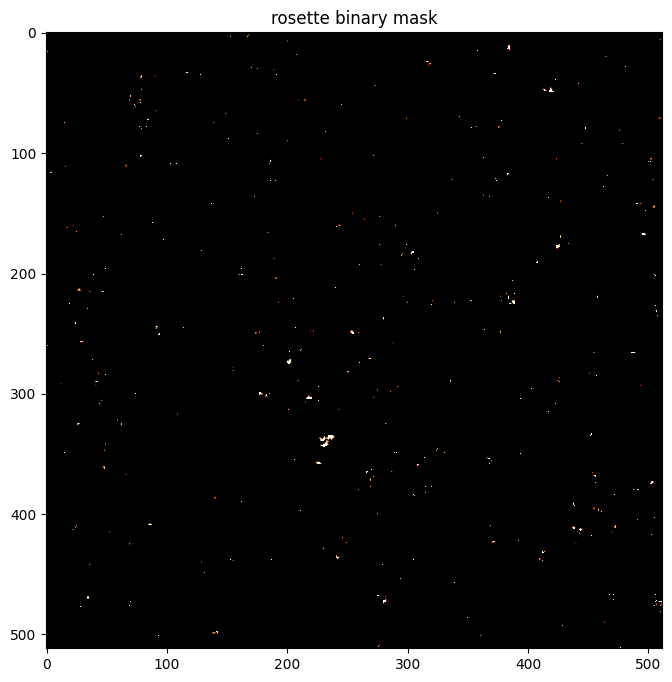

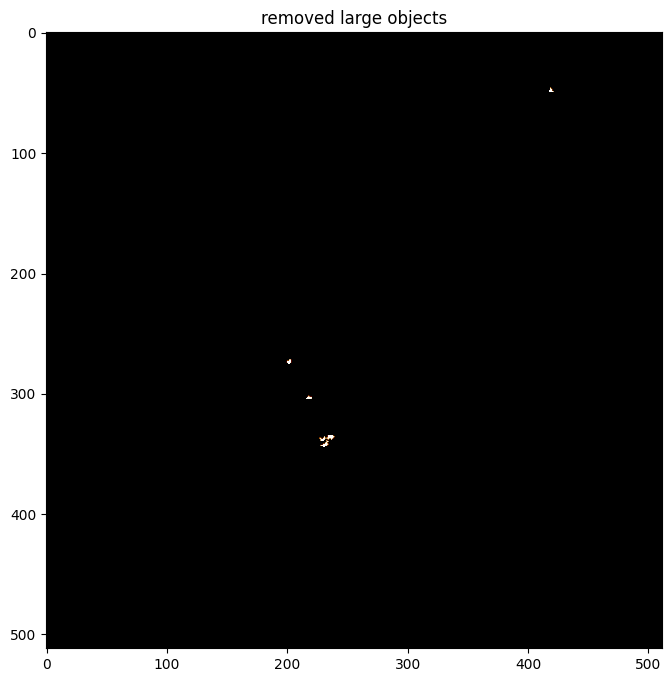

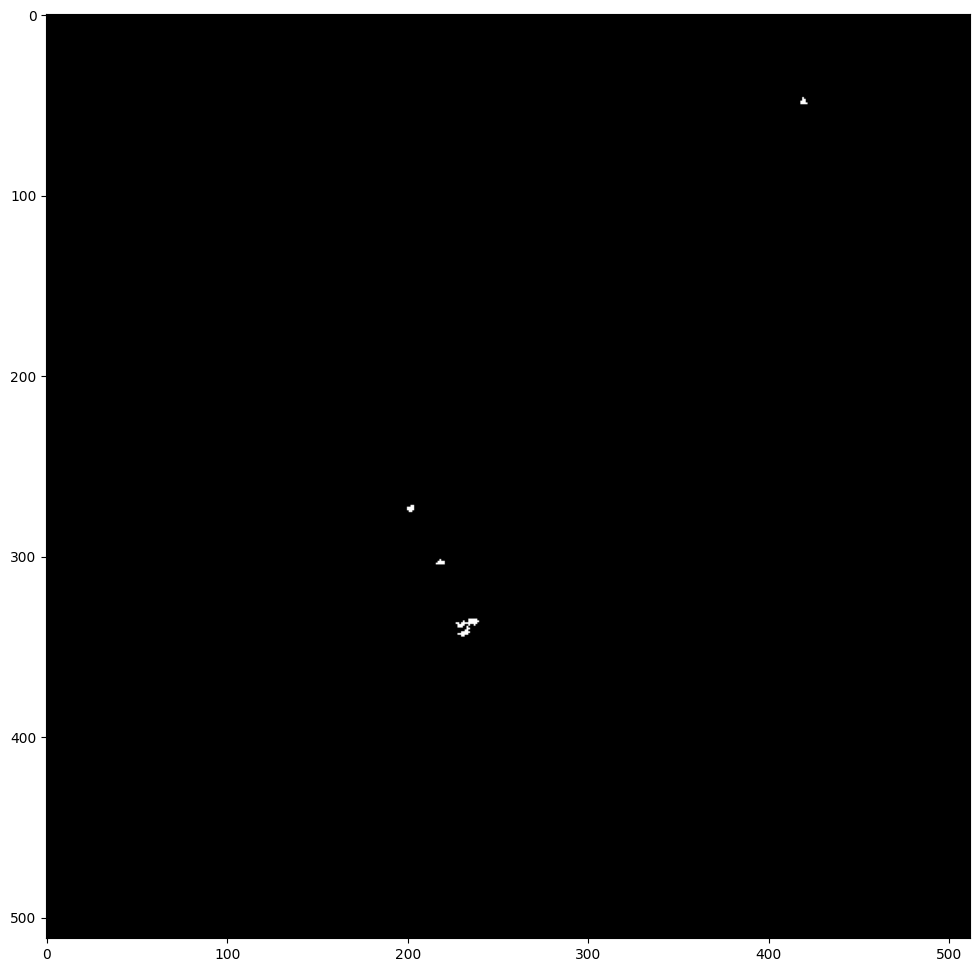

In [130]:
# Locate Nodes

rosette_thresholds = topofilters.get_thresholds(
    flattened, threshold_method="std_dev", threshold_std_dev={"upper": 3, "lower": None}
)

print(f"thresholds: {rosette_thresholds}")
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title="rosette binary mask", zlimit=False)

# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, 10)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > 750:
        labelled_rosette_mask[labelled_rosette_mask == props.label] = 0

plot(labelled_rosette_mask.astype(bool), title="removed large objects", zlimit=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(labelled_rosette_mask.astype(bool), cmap="gray")

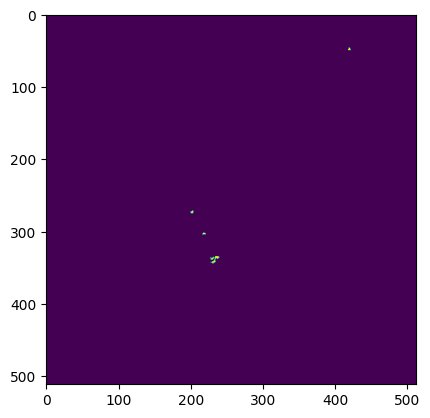

In [131]:
plt.imshow(labelled_rosette_mask.astype(bool))
plt.show()
import network_stats

dir(network_stats)
# Find node centroid coordinates
node_centroids = network_stats.get_node_centroids(labelled_rosette_mask)
# Find node areas
node_areas = network_stats.node_stats(labelled_rosette_mask, flattened)["node areas"]

In [132]:
height_thres = 0.5
strand_multi = 1.5
radius = 25
# fibril 35, cap 25

0.2
29.0
23.0
29.0
13.0
Average strand coordination: 16.75
Peak Areas: [[9.814097481606005, 0.34610136832597227, 3.7526594202774124, 0.937649480219444, 6.325796614335657, 1.0969741439070577, 0.08666004677434286, 3.176549158982096, 2.9772089184104447, 6.620189060552949, 1.6458586161373043, 3.70876094364824, 0.8249700341006909, 0.02300097360042101, 3.2789935680471274, 0.45383951854941246, 3.0611248798816155, 7.327361883336317], [4.774767615593729, 4.857230069504078, 0.3503909249127646, 0.02868598240719674, 21.97947075120219, 4.540306611260748, 2.5861491399425733, 7.6759800587343925, 1.4587445388161548, 2.57868556703965, 10.39724229697795, 1.2551190142701838, 9.233646068248476, 0.3812659324933653, 2.1569072419694146, 0.4294170140311102, 0.2223093276396774], [4.5177060863746785, 0.3062852724283751, 4.552841098528798, 2.9682919130955137, 1.100688624930755, 5.044881839266227, 3.394943605372441, 451.83191054284356, 4.576953966745924, 3.243102100677074, 0.09179213755067925, 3.105515278565935, 

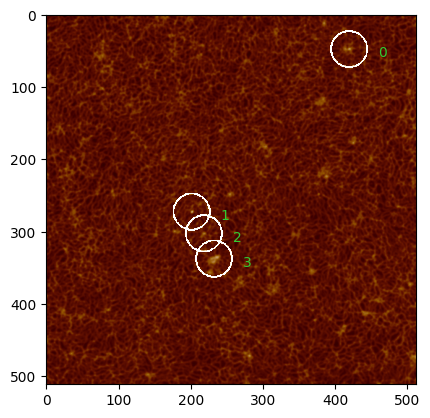

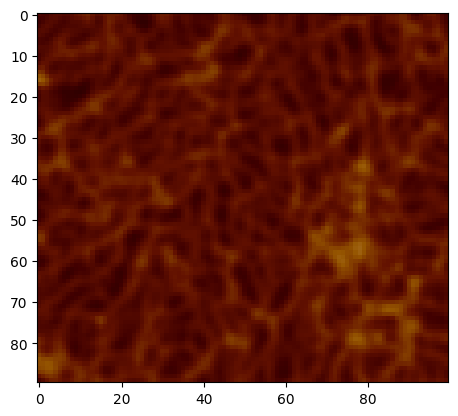

In [133]:
# Create circular masks around each nodes and extract heights

circle_mask = gaussian(
    flattened.copy(), sigma=1.0
)  # Copy of flattened for gathering heights with small gaussian blur to regulate values
circle_image = circle_mask  # Create second mask for drawing on
im_width = math.sqrt(circle_mask.size)
circ_nm = radius * 2 * np.pi * p_to_nm  # circumference of masked circle in nm
region_values, included, area_tot, counts, region_peakarea, branch_counts, strands_count_all, node_area_cut = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)


# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)


# Finds the background/surface height using a manual sample - Use only for cap
# back_region = circle_image[200:400, 0:200]
# back_height = np.average(back_region)+height_thres
back_height = 0.2
print(back_height)
# plt.imshow(back_region, vmin=-3, vmax=4, cmap=cmap)
# plt.show()

# need a list of centroids of the circles that satisfy
# the conditions, so we can label them in the image
# iteratively
filtered_circle_centroids = []
for k, centroid in enumerate(node_centroids):
    rr, cc = draw.circle_perimeter(int(centroid[0]), int(centroid[1]), radius, method="bresenham")
    inc_nm = circ_nm / len(rr)  # spacing between pixels

    if any((i < 0 or i > im_width) for i in rr) or any((j < 0 or j > im_width) for j in cc):
        None  # Ignores points outside of the surveyed region
    else:
        # separates rr,cc into XY pairs
        XY = [i for i in zip(rr, cc)]
        # Sort the points based on their angles around the centroid
        indices = np.argsort([angle(point, centroid) for point in XY])
        sorted, rr_sort, cc_sort = [], [], []
        for i in indices:
            sorted.append(XY[i])
        for j in sorted:
            rr_sort.append(j[0])
            cc_sort.append(j[1])
        # Extracts perimeter values
        perimeter_values = circle_mask[rr_sort, cc_sort]
        # Applies threshold
        perimeter_strands = np.clip(circle_mask[rr_sort, cc_sort] - back_height, 0, 1000)

        # Scans around the mask, identifiying peaks, calcualting area and estimating number of strands
        prev, count, trparea = 0, 0, 0
        peak_areas, strand_count = [], []
        for height in perimeter_strands:
            if height > 0 and prev >= 0:
                trparea = trparea + 0.5 * (height - prev) * inc_nm + prev * inc_nm
            elif height == 0 and prev > 0:
                trparea = trparea + 0.5 * (height - prev) * inc_nm + prev * inc_nm
                peak_areas.append(trparea)
                if trparea < 10:
                    strand = math.ceil(trparea / (math.sqrt(trparea) * strand_multi))
                    strand_count = np.append(strand_count, strand)
                trparea = 0
            prev = height

        branch_count = len(peak_areas)
        strands_count_all = np.append(strands_count_all, strand_count)
        print(sum(strand_count))

        # Appends branch/strand data to list from all nodes
        branch_counts = np.append(branch_counts, branch_count)
        region_peakarea.append(peak_areas)
        region_values.append(perimeter_values)
        node_area_cut.append(node_areas[k])

        circle_image[rr_sort, cc_sort] = 100
        area_tot = np.trapz(region_values, dx=5)
        # print("Area:",area_tot)

        filtered_circle_centroids.append(centroid)
print("Average strand coordination:", (sum(branch_counts) / len(branch_counts)))
# print("Average branch coordination:",(sum(strands_count_all)/len(strands_count_all)))
# print(strands_count_all)
# print(node_area_cut)
print("Peak Areas:", region_peakarea)
for p in node_area_cut:
    print(p)

plt.imshow(circle_image, vmin=-3, vmax=4, cmap=cmap)
for index, centroid in enumerate(filtered_circle_centroids):
    plt.text(centroid[1] + 40, centroid[0] + 10, f"{index}", color="limegreen")
plt.show()

subsection = circle_image[0:90, 0:100]
plt.imshow(subsection, vmin=-3, vmax=4, cmap=cmap)
plt.show()

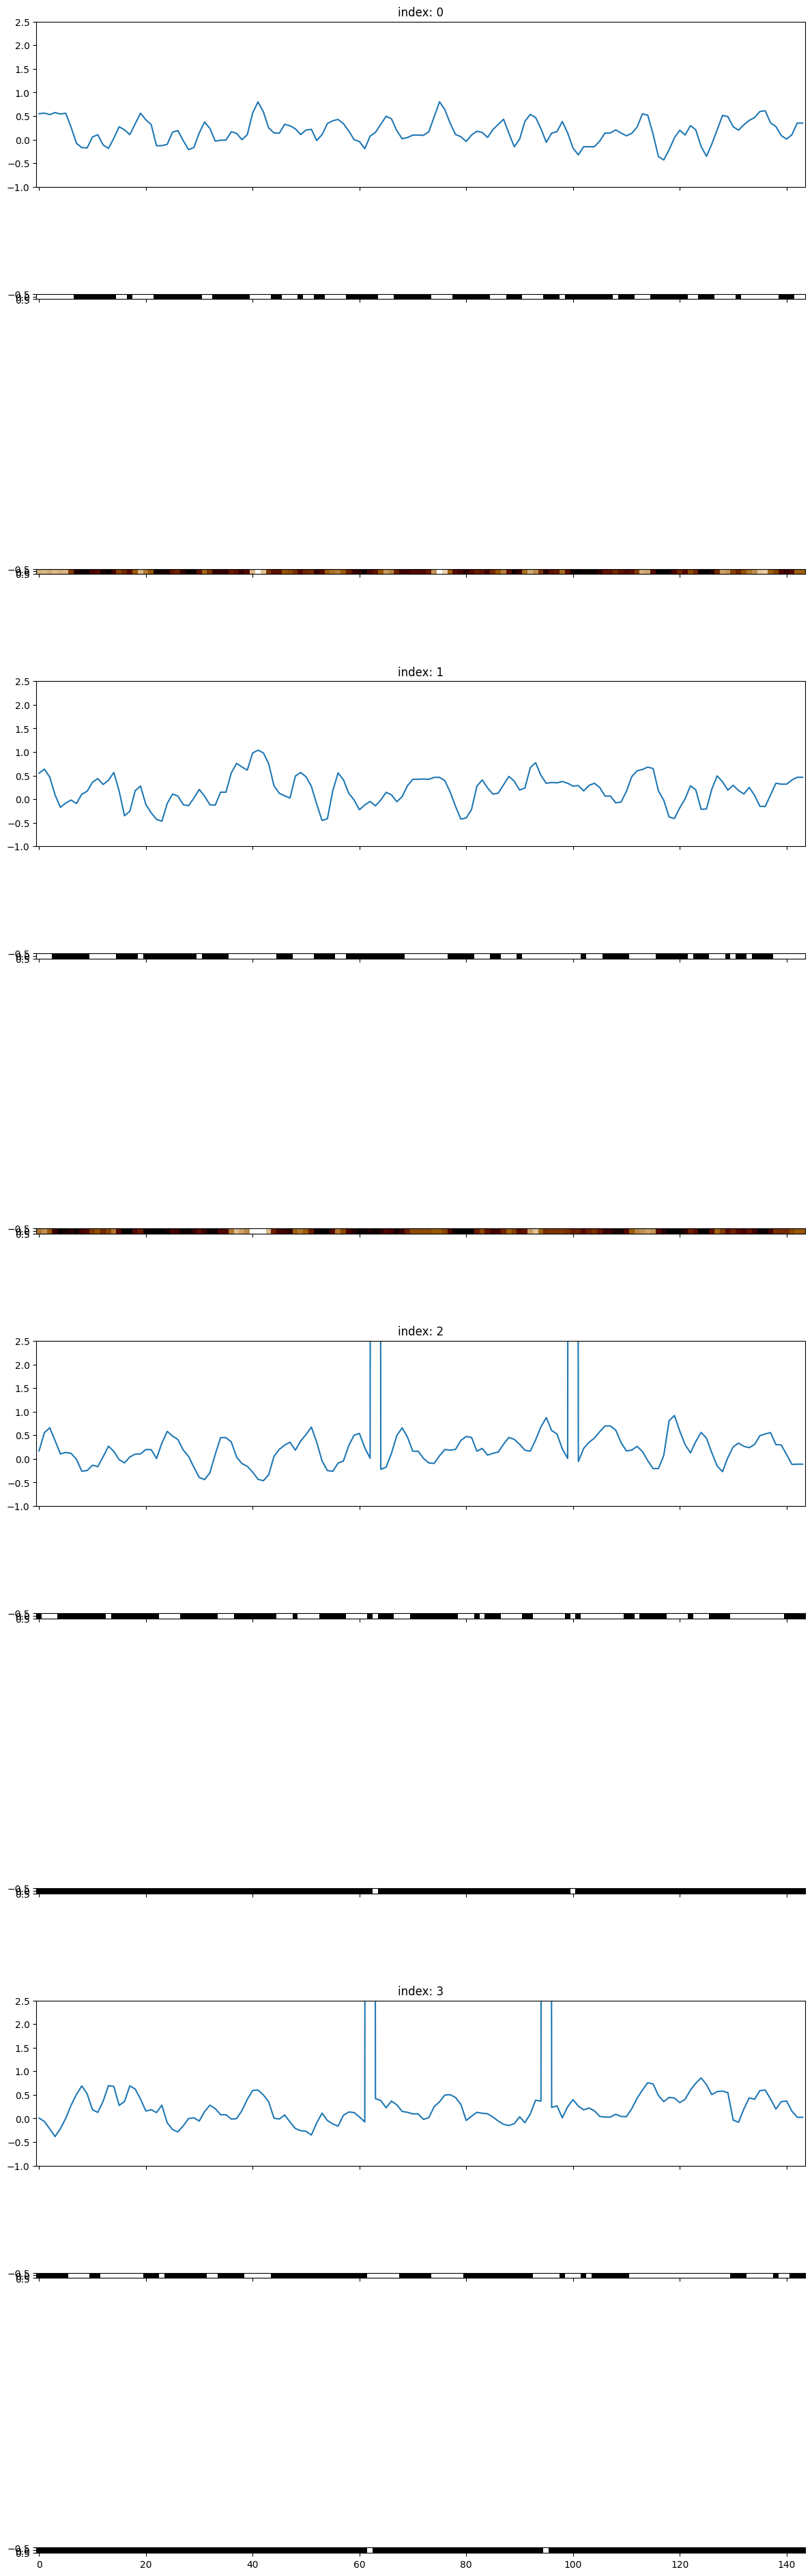

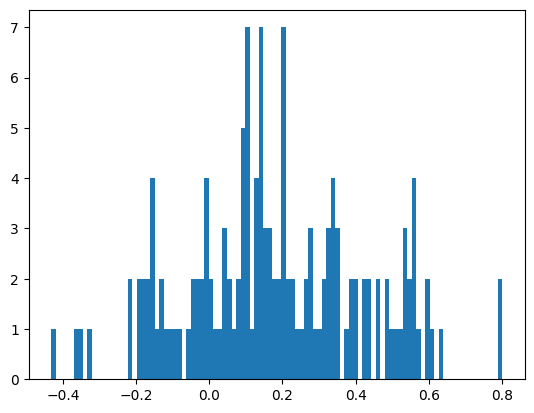

"\n#Single plot\ni = 0\nvalues = region_values[0]\nfor j in values:\n    print(j)\nfor k,point in enumerate(values):\n    print(inc_nm*k)\nfig, ax = plt.subplots(3,1,figsize=(12, 3), sharex=True)\nax[0].set_ylim(-1, 2.5)\nax[0].plot(values)\nax[1].imshow(np.array([values > 0.5]), cmap=cmap)\nax[2].imshow(np.array([values]), cmap=cmap)\nax[0].set_title(f'index: {i}')\nfig.tight_layout()\nplt.show()\n#"

In [134]:
# Plot height trace with pixels and estimated branch widths

height_ratios = [1, 2, 2] * len(region_values)
fig, ax = plt.subplots(
    len(region_values * 3), 1, figsize=(12, 40), sharex=True, gridspec_kw={"height_ratios": height_ratios}
)
for i, values in enumerate(region_values):
    ax[i * 3].set_ylim(-1, 2.5)
    ax[i * 3].plot(values)
    ax[i * 3 + 1].imshow(np.array([values > back_height]), cmap=cmap)
    ax[i * 3 + 2].imshow(np.array([values]), cmap=cmap)
    ax[i * 3].set_title(f"index: {i}")
fig.tight_layout()
plt.show()
index = 0
values = region_values[index]
fig, ax = plt.subplots()
ax.hist(values, bins=100)
plt.show()
"""
#Single plot
i = 0
values = region_values[0]
for j in values:
    print(j)
for k,point in enumerate(values):
    print(inc_nm*k)
fig, ax = plt.subplots(3,1,figsize=(12, 3), sharex=True)
ax[0].set_ylim(-1, 2.5)
ax[0].plot(values)
ax[1].imshow(np.array([values > 0.5]), cmap=cmap)
ax[2].imshow(np.array([values]), cmap=cmap)
ax[0].set_title(f'index: {i}')
fig.tight_layout()
plt.show()
#"""